# MNIST Handwritten Digit Generation using GAN

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('Running TF without GPU')
else:
    print(f'Found GPU at {device_name}')

Running TF without GPU


In [2]:
%matplotlib inline

import glob
import imageio
import os
import seaborn as sn

from abc import abstractstaticmethod
from matplotlib import pyplot as plt
from tensorflow import keras

sn.set_theme()

In [3]:
NOISE_DIMENSION = 128
TRAIN_SIZE = 60000
TEST_SIZE = 10000
BATCH_SIZE = 32
EPOCHS = 50

EPSILON = 1e-7
N_EXAMPLES = 12
G_LEARNING_RATE = 1e-4
D_LEARNING_RATE = 1e-4

ARCH = 'gan'
METRICS_PATH = f'metrics/{ARCH}/'
OUTPUT_PATH = f'output/{ARCH}/'

!mkdir -p $METRICS_PATH
!mkdir -p $OUTPUT_PATH

In [4]:
assert NOISE_DIMENSION > 0
assert TRAIN_SIZE <= 600000
assert BATCH_SIZE >= 1
assert EPOCHS >= 1
assert N_EXAMPLES >= 1
assert G_LEARNING_RATE > 0
assert D_LEARNING_RATE > 0

## Base Class

In [5]:
class BaseNetwork(tf.Module):
    def __init__(self):
        super().__init__()

    @tf.Module.with_name_scope
    def __call__(self, input_data, training=False) -> tf.Tensor:
        output_data = input_data
        for layer in self.layers:
            output_data = layer(output_data, training=training)
        return output_data

    @abstractstaticmethod
    def loss() -> tf.Tensor:
        raise NotImplementedError

    @abstractstaticmethod
    def optimizer(*args, **kwargs) -> tf.optimizers.Optimizer:
        raise NotImplementedError

## Generator Network
### Layers
<pre>
Input: input_size=(128, 1)
Dense:
</pre>

### Optimizer
<pre>
Adam:  learning_rate=0.0002`
</pre>

### Loss
&#8466;<sub>G</sub>(<i><b>z</b></i>) = <sup>-1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> log(<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))

### Goal
Find argmin<sub>G</sub> {&#8466;<sub>G</sub>(<i><b>z</b></i>)}

In [6]:
class Generator(BaseNetwork):
    def __init__(self, noise_dimension: int, output_shape: tuple) -> None:
        super().__init__()
        # Network layers
        self.layers = [
            keras.layers.InputLayer(input_shape=(noise_dimension,)),
            keras.layers.Flatten(),
            keras.layers.Dense(units=128),
            keras.layers.ReLU(),
            keras.layers.Dense(units=128),
            keras.layers.ReLU(),
            keras.layers.Dense(units=256),
            keras.layers.ReLU(),
            keras.layers.Dense(units=512),
            keras.layers.ReLU(),
            keras.layers.Dense(units=512),
            keras.layers.Dense(units=tf.reduce_prod(output_shape)),
            keras.layers.Reshape(target_shape=output_shape),
            keras.layers.Activation(tf.nn.tanh),
        ]

    @staticmethod
    def optimizer(learning_rate: float, momentum: float=0.0) -> tf.optimizers.Optimizer:
        return tf.optimizers.Adam(learning_rate=learning_rate)

    @staticmethod
    @tf.function
    def loss(generated_output):
        loss_i = tf.math.log(generated_output)
        loss = -tf.math.reduce_mean(loss_i)
        return loss

## Discriminator Network
### Layers
<pre>
<b>Input</b>:        input_size=(28, 28, 1)
</pre>

### Optimizer
<pre>
<b>Adam</b>:         learning_rate=0.0002
</pre>

### Loss
&#8466;<sub>D</sub>(<i><b>x</b>,<b>z</b>) = <sup>-1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> \[log <i>D</i>(<i><b>x</b><sup>(i)</sup></i>) + log (1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))\]

### Goal
Find argmin<sub>D</sub> &#8466;<sub>D</sub>(<i><b>x</b></i>,<i><b>z</b></i>)

In [7]:
class Discriminator(BaseNetwork):
    def __init__(self, input_shape: tuple) -> None:
        super().__init__()
        # Network layers
        self.layers = [
            keras.layers.InputLayer(input_shape=input_shape),
            keras.layers.Flatten(),
            keras.layers.Dense(units=512),
            keras.layers.ReLU(),
            keras.layers.Dropout(rate=0.4),
            keras.layers.Dense(units=512),
            keras.layers.ReLU(),
            keras.layers.Dropout(rate=0.3),
            keras.layers.Dense(units=256),
            keras.layers.ReLU(),
            keras.layers.Dropout(rate=0.3),
            keras.layers.Dense(units=128),
            keras.layers.ReLU(),
            keras.layers.Dropout(rate=0.1),
            keras.layers.Dense(units=64),
            keras.layers.ReLU(),
            keras.layers.Dense(units=1),
            keras.layers.Activation(tf.nn.sigmoid),
        ]

    @staticmethod
    def optimizer(learning_rate: float, momentum: float=0.0):
        return tf.optimizers.Adam(learning_rate=learning_rate)

    @staticmethod
    @tf.function
    def loss(trained_ouput, generated_output) -> tf.Tensor:
        loss_i = tf.math.log(trained_ouput) + tf.math.log(1-generated_output)
        loss = -tf.math.reduce_mean(loss_i)
        return loss

## Preprocessing
* Import MNIST training images
* Normalize to \[-1, 1\]
* Shuffle and batch dataset

In [8]:
(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()

train_images = tf.dtypes.cast((train_images[:TRAIN_SIZE]-127.5) / 127.5, tf.float32)
train_images = tf.expand_dims(input=train_images, axis=-1)
train_ds = tf.data.Dataset.from_tensor_slices(train_images) \
                          .shuffle(TRAIN_SIZE) \
                          .batch(BATCH_SIZE)

test_images = tf.dtypes.cast((train_images[:TEST_SIZE]-127.5) / 127.5, tf.float32)

### Initialize Generator and Discriminator

In [9]:
generator = Generator(noise_dimension=NOISE_DIMENSION, output_shape=(train_images.shape[1:]))
generator_optimizer = generator.optimizer(G_LEARNING_RATE)

discriminator = Discriminator(input_shape=(train_images.shape[1:]))
discriminator_optimizer = discriminator.optimizer(D_LEARNING_RATE)

In [10]:
fixed_noise = tf.random.normal([N_EXAMPLES, NOISE_DIMENSION])
metrics_names = ['g_loss', 'd_loss', 'acc', 'real_acc', 'fake_acc']
batch_history = { name: [] for name in metrics_names }
epoch_history = { name: [] for name in metrics_names }

In [11]:
def view_sample(generator: Generator, epoch: int, test_input: tf.Tensor, save: bool=True, show=True):
    predictions = generator(test_input, training=False)

    plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i]*127.5 + 127.5, cmap=plt.cm.gray)
        plt.axis('off')

    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'epoch_{:04d}.png'.format(epoch)))
    if show:
        plt.show()
    plt.close()

### Accuracy

In [12]:
def real_accuracy(real_output) -> tf.Tensor(dtype=tf.float32):
    # Trained images fed into D have output 1 
    correct_real_output = tf.ones_like(real_output)
    real_acc = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(tf.math.round(real_output), correct_real_output), tf.float32))
    return real_acc

def accuracy(fake_output, real_output) -> tuple:
    # Images from G's noisy distribution should have output 0 from D
    correct_fake_output = tf.zeros_like(fake_output)
    fake_acc = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(tf.math.round(fake_output), correct_fake_ouput), tf.float32))

    return real_accuracy(real_output), fake_acc

## GAN Algorithm
<pre>
<b>for</b> number of training iterations <b>do</b>
  <b>for</b> k steps <b>do</b>
     • Sample minibatch of <i>m</i> noise samples {<i><b>z</b><sup>(1)</sup>, ..., <b>z</b><sup>(m)</sup></i>} from noise prior <i>p<sub>g</sub>(<b>z</b>)</i>.
     • Sample minibatch of <i>m</i> examples {<i><b>x</b><sup>(1)</sup>, ..., <b>x</b><sup>(m)</sup></i>} from data generating distribution <i>p<sub>data</sub>(<b>x</b>)</i>.
     • Update the discriminator by <u>ascending</u> its stochastic gradient:
       <center>&Del;<sub>&theta;<sub>d</sub></sub> <sup>1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> [log <i>D</i>(<i><b>x</b><sup>(i)</sup></i>) + log(1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))]</center>
  <b>end for</b>
  • Sample minibatch of <i>m</i> noise samples {<i><b>z</b><sup>(1)</sup>, ..., <b>z</b><sup>(m)</sup></i>} from noise prior <i>p<sub>g</sub>(<b>z</b>)</i>.
  • Update the generator by <u>descending</u> its stochastic gradient:
  <center>&Del;<sub>&theta;<sub>d</sub></sub> <sup>1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> log(1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))</center>
<b>end for</b>
</pre>

Source: https://arxiv.org/pdf/1406.2661.pdf

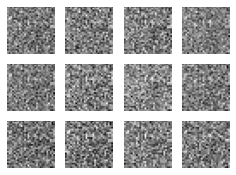


epoch 1/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 1.9584 - d_loss: 0.8922 - acc: 0.8125 - real_acc: 0.7500 - fake_acc: 0.8750 ETA: 1s - g_loss: 2.0343 - d_loss: 0.6206 - acc: 0.8750 - real_acc: 0.9375 - fake_acc:  - ETA: 0s - g_loss: 1.8741 - d_loss: 0.5330 - acc: 0.8906 - real_acc: 0.9375 - fake_acc: 0.84 - ETA: 0s - g_loss: 1.5690 - d_loss: 0.8155 - acc: 0.8125 - real_acc: 0.8438 - fake_acc:  - ETA: 0s - g_loss: 1.7759 - d_loss: 1.0878 - acc: 0.7812 - real_acc: 0.7500 - fake_acc: 0.
epoch 2/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.9126 - d_loss: 1.2358 - acc: 0.6406 - real_acc: 0.4375 - fake_acc: 0.8438   - ETA: 10:33 - g_loss: 1.3889 - d_loss: 1.9580 - acc: 0.5781 - real_a

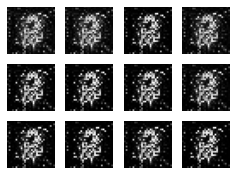


epoch 3/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 2.2208 - d_loss: 0.9612 - acc: 0.7656 - real_acc: 0.5312 - fake_acc: 1.0000
epoch 4/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 1.0894 - d_loss: 1.0056 - acc: 0.7812 - real_acc: 0.8125 - fake_acc: 0.7500

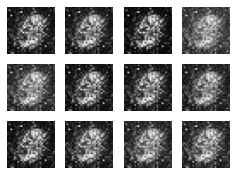


epoch 5/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 2.6822 - d_loss: 0.3942 - acc: 0.9219 - real_acc: 0.8438 - fake_acc: 1.0000
epoch 6/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.9449 - d_loss: 1.4388 - acc: 0.6250 - real_acc: 0.5000 - fake_acc: 0.7500

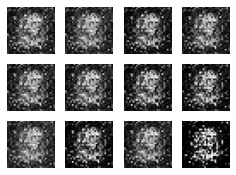


epoch 7/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 1.1421 - d_loss: 1.0663 - acc: 0.7656 - real_acc: 0.6562 - fake_acc: 0.8750
epoch 8/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 1.1353 - d_loss: 0.8845 - acc: 0.7656 - real_acc: 0.6562 - fake_acc: 0.8750

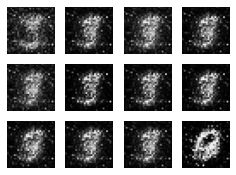


epoch 9/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 1.0840 - d_loss: 1.0893 - acc: 0.7031 - real_acc: 0.5625 - fake_acc: 0.8438

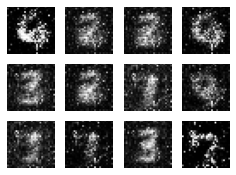


epoch 13/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 1.0973 - d_loss: 1.0863 - acc: 0.6875 - real_acc: 0.5000 - fake_acc: 0.8750
epoch 14/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.9323 - d_loss: 1.4723 - acc: 0.5312 - real_acc: 0.4375 - fake_acc: 0.6250

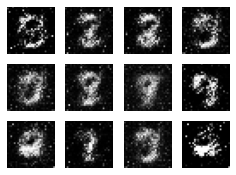


epoch 15/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 1.1440 - d_loss: 0.8706 - acc: 0.8281 - real_acc: 0.7812 - fake_acc: 0.8750
epoch 16/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 1.0764 - d_loss: 0.9961 - acc: 0.7188 - real_acc: 0.6562 - fake_acc: 0.7812

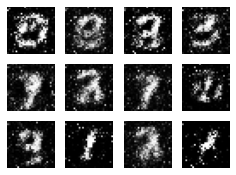


epoch 17/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.9615 - d_loss: 1.0275 - acc: 0.7188 - real_acc: 0.6250 - fake_acc: 0.8125
epoch 18/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.9814 - d_loss: 1.1535 - acc: 0.6875 - real_acc: 0.5312 - fake_acc: 0.8438

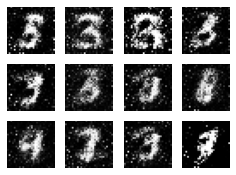


epoch 19/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 1.0178 - d_loss: 1.1310 - acc: 0.6719 - real_acc: 0.4688 - fake_acc: 0.8750
epoch 20/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.9723 - d_loss: 1.1548 - acc: 0.6875 - real_acc: 0.5625 - fake_acc: 0.8125

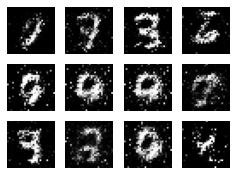


epoch 21/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.8390 - d_loss: 1.2868 - acc: 0.5938 - real_acc: 0.4688 - fake_acc: 0.7188
epoch 22/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7759 - d_loss: 1.3895 - acc: 0.5469 - real_acc: 0.4688 - fake_acc: 0.6250

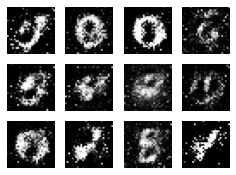


epoch 23/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7629 - d_loss: 1.2573 - acc: 0.6094 - real_acc: 0.5312 - fake_acc: 0.6875
epoch 24/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7709 - d_loss: 1.2913 - acc: 0.6094 - real_acc: 0.6250 - fake_acc: 0.5938

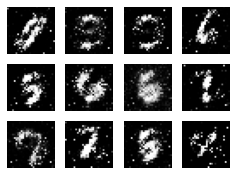


epoch 25/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.9149 - d_loss: 1.1357 - acc: 0.7188 - real_acc: 0.6250 - fake_acc: 0.8125
epoch 26/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7574 - d_loss: 1.2881 - acc: 0.7031 - real_acc: 0.5625 - fake_acc: 0.8438

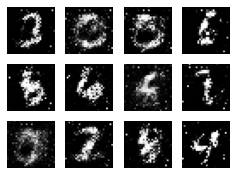


epoch 27/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7730 - d_loss: 1.2448 - acc: 0.6406 - real_acc: 0.6250 - fake_acc: 0.6562
epoch 28/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7976 - d_loss: 1.2997 - acc: 0.6406 - real_acc: 0.5625 - fake_acc: 0.7188

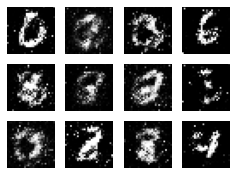


epoch 29/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.8382 - d_loss: 1.3718 - acc: 0.5938 - real_acc: 0.4375 - fake_acc: 0.7500
epoch 30/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7804 - d_loss: 1.3180 - acc: 0.5938 - real_acc: 0.4688 - fake_acc: 0.7188

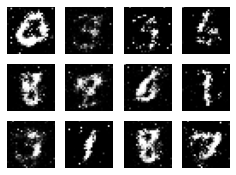


epoch 31/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7463 - d_loss: 1.3675 - acc: 0.5938 - real_acc: 0.5000 - fake_acc: 0.6875
epoch 32/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7262 - d_loss: 1.3643 - acc: 0.5781 - real_acc: 0.5000 - fake_acc: 0.6562

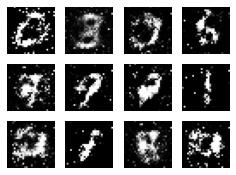


epoch 33/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7429 - d_loss: 1.3733 - acc: 0.5156 - real_acc: 0.2812 - fake_acc: 0.7500
epoch 34/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7435 - d_loss: 1.3544 - acc: 0.5469 - real_acc: 0.4062 - fake_acc: 0.6875

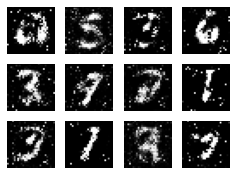


epoch 35/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.8024 - d_loss: 1.3230 - acc: 0.5781 - real_acc: 0.3438 - fake_acc: 0.8125
epoch 36/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7512 - d_loss: 1.2306 - acc: 0.6562 - real_acc: 0.6562 - fake_acc: 0.6562

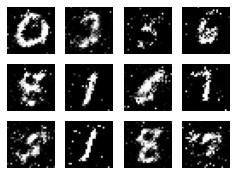


epoch 37/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7650 - d_loss: 1.4335 - acc: 0.4688 - real_acc: 0.2188 - fake_acc: 0.7188
epoch 38/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7800 - d_loss: 1.2899 - acc: 0.5938 - real_acc: 0.3750 - fake_acc: 0.8125

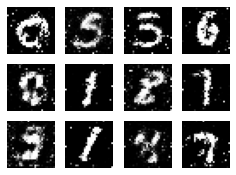


epoch 39/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.8203 - d_loss: 1.2821 - acc: 0.6094 - real_acc: 0.4062 - fake_acc: 0.8125
epoch 40/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7463 - d_loss: 1.4327 - acc: 0.5312 - real_acc: 0.5000 - fake_acc: 0.5625

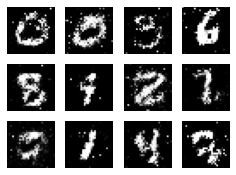


epoch 41/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7447 - d_loss: 1.3567 - acc: 0.6250 - real_acc: 0.4375 - fake_acc: 0.8125
epoch 42/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7032 - d_loss: 1.3374 - acc: 0.6250 - real_acc: 0.5938 - fake_acc: 0.6562

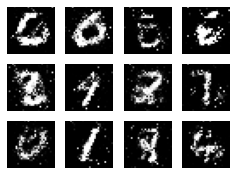


epoch 43/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.8073 - d_loss: 1.4273 - acc: 0.5000 - real_acc: 0.1875 - fake_acc: 0.8125
epoch 44/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7461 - d_loss: 1.4044 - acc: 0.4688 - real_acc: 0.2500 - fake_acc: 0.6875

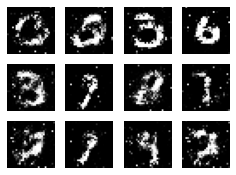


epoch 45/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7396 - d_loss: 1.4190 - acc: 0.5000 - real_acc: 0.3438 - fake_acc: 0.6562
epoch 46/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.8111 - d_loss: 1.2423 - acc: 0.6562 - real_acc: 0.5625 - fake_acc: 0.7500

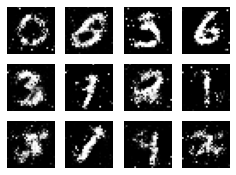


epoch 47/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7465 - d_loss: 1.3005 - acc: 0.6562 - real_acc: 0.5312 - fake_acc: 0.7812
epoch 48/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7733 - d_loss: 1.2350 - acc: 0.6719 - real_acc: 0.5938 - fake_acc: 0.7500

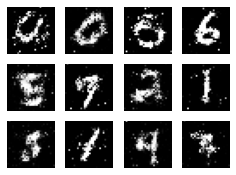


epoch 49/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.8149 - d_loss: 1.1994 - acc: 0.7188 - real_acc: 0.6250 - fake_acc: 0.8125
epoch 50/50
1874/1875 [============================>.] - ETA: 0s - g_loss: 0.7370 - d_loss: 1.3452 - acc: 0.6719 - real_acc: 0.6250 - fake_acc: 0.7188

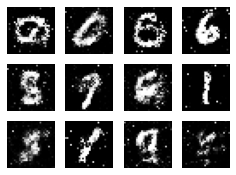

In [13]:
view_sample(generator, 1, fixed_noise)
steps_per_epoch = train_images.shape[0] // BATCH_SIZE

for epoch in range(1, EPOCHS+1):
    print(f'\nepoch {epoch}/{EPOCHS}')
    progress_bar = keras.utils.Progbar(steps_per_epoch, stateful_metrics=metrics_names)

    for i, image_batch in enumerate(train_ds):

        num_samples = image_batch.shape[0]
        noise = tf.random.normal([num_samples, NOISE_DIMENSION])

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            # Train G on noise
            generated_images = generator(noise, training=True)
            # Train D on training images
            trained_output = discriminator(image_batch, training=True)
            # Train D on generated images
            generated_output = discriminator(generated_images, training=True)

            # Calculate loss
            g_loss = generator.loss(generated_output)
            d_loss = discriminator.loss(trained_output, generated_output)

        real_acc, fake_acc = accuracy(trained_output, generated_output)
        acc = 0.5 * (real_acc + fake_acc)

        training_metrics = {
            'g_loss': g_loss,
            'd_loss': d_loss,
            'acc': acc,
            'real_acc': real_acc,
            'fake_acc': fake_acc,
        }

        # Record loss history
        for metric in batch_history:
            batch_history[metric].append(training_metrics[metric])
    
        metric_values = updated_metrics.items()
        progress_bar.update(min(i, steps_per_epoch), values=metric_values)        

        # https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient
        grad_g = g_tape.gradient(g_loss, generator.trainable_variables)
        grad_d = d_tape.gradient(d_loss, discriminator.trainable_variables)

        # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients
        generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))

    
    validation_metrics = {
        'val_real_acc': 0.,
    }
        
    if epoch % 2 == 0:
        view_sample(generator, epoch, fixed_noise)
    else:
        view_sample(generator, epoch, fixed_noise, show=False)

if EPOCHS % 10 != 0:
    view_sample(generator, EPOCHS, fixed_noise)

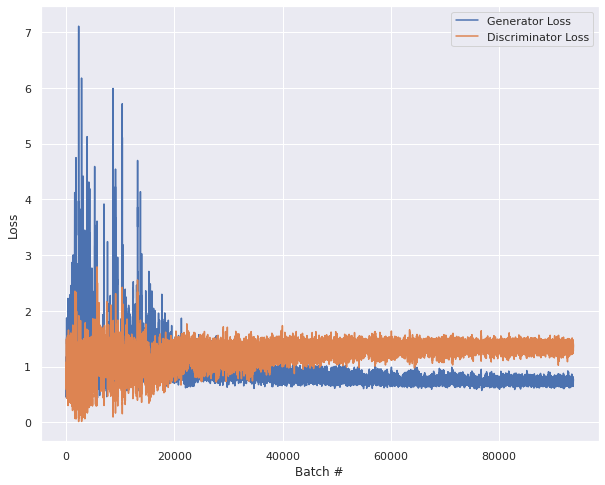

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(batch_history['g_loss'], label='Generator Loss')
plt.plot(batch_history['d_loss'], label='Discriminator Loss')
plt.xlabel('Batch #')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(METRICS_PATH, 'loss.png'))
plt.show()
plt.close()

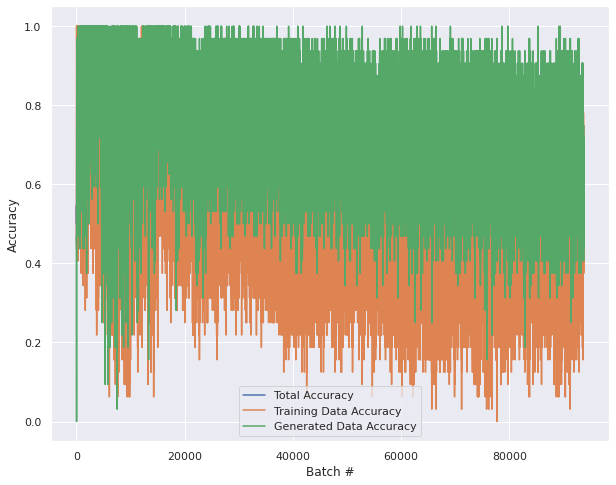

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(batch_history['acc'], label='Total Accuracy')
plt.plot(batch_history['real_acc'], label='Training Data Accuracy')
plt.plot(batch_history['fake_acc'], label='Generated Data Accuracy')
plt.xlabel('Batch #')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(METRICS_PATH, 'accuracy.png'))
plt.show()
plt.close()

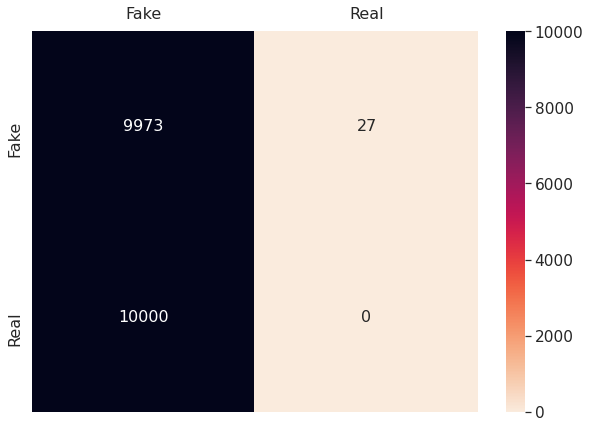

In [16]:
real_test_preds = tf.dtypes.cast(tf.math.round(discriminator(test_images, training=False)), tf.float32)
fake_test_preds = tf.dtypes.cast(tf.math.round(discriminator(tf.random.normal(test_images.shape), training=False)), tf.float32)
real_labels = tf.ones_like(real_test_preds)
fake_labels = tf.zeros_like(fake_test_preds)
preds = tf.concat([real_test_preds, fake_test_preds], axis=0)
labels = tf.concat([real_labels, fake_labels], axis=0)
preds = tf.squeeze(preds)
labels = tf.squeeze(labels)
named_labels = ['Fake', 'Real']
confusion_matrix = tf.math.confusion_matrix(labels, preds, num_classes=2).numpy()
plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix, annot=True, annot_kws={'size': 14}, fmt='d', cmap=sn.cm.rocket, xticklabels=named_labels, yticklabels=named_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(METRICS_PATH, 'confusion_matrix.png'))
plt.show()
plt.close()

In [ ]:
normal_confusion_matrix = confusion_matrix.numpy()
normal_confusion_matrix = np.divide(normal_confusion_matrix.astype('float'), normal_confusion_matrix.sum(axis=1)[:, np.newaxis])
plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix, annot=True, annot_kws={'size': 14}, fmt='d', cmap=sn.cm.rocket, xticklabels=named_labels, yticklabels=named_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(METRICS_PATH, 'confusion_matrix.png'))
plt.show()
plt.close()

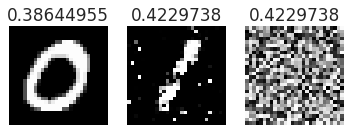

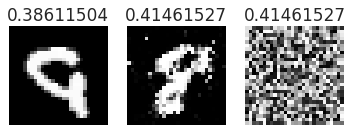

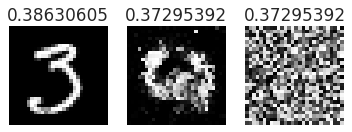

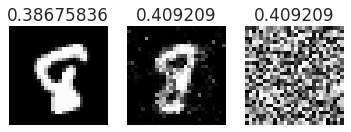

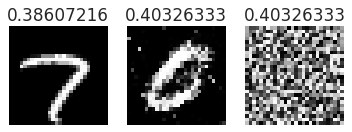

In [25]:
for _ in range(5):
    real_test_image = test_images[tf.random.uniform(shape=(), minval=0, maxval=TEST_SIZE+1, dtype=tf.int32)]
    fake_test_image_1 = generator(tf.random.normal([1, NOISE_DIMENSION]), training=False)
    fake_test_image_2 = tf.nn.tanh(tf.random.normal(train_images.shape[1:]))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(real_test_image, cmap=plt.cm.gray)
    ax1.axis('off')
    real_test_image = tf.expand_dims(input=real_test_image, axis=0)
    ax1.set_title(discriminator(real_test_image, training=False).numpy()[0][0])

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(fake_test_image_1[0, :, :, 0], cmap=plt.cm.gray)
    ax2.axis('off')
    ax2.set_title(discriminator(fake_test_image_1, training=False).numpy()[0][0])

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(fake_test_image_2, cmap=plt.cm.gray)
    ax3.axis('off')
    fake_test_image_2 = tf.expand_dims(input=fake_test_image_2, axis=0)
    ax3.set_title(discriminator(fake_test_image_1, training=False).numpy()[0][0])

    plt.show()
    plt.close()

In [19]:
with imageio.get_writer(os.path.join(METRICS_PATH, 'dcgan.gif'), mode='I') as writer:
    filenames = glob.glob(os.path.join(OUTPUT_PATH, 'epoch*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)